BERT for NER using BERTForTokenClassification 

In [1]:
import pandas as pd

annotations = pd.read_csv("./annotations.csv", index_col = ['id'])

In [2]:
annotations

,sentence#,token,tag,relabelled_tags
id,,,,
0,0,Om,CONCEPT,2
1,0,!,O,0
2,1,Having,O,0
3,1,bowed,O,0
4,1,down,O,0
...,...,...,...,...
830510,34331,The,O,0
830511,34331,end,O,0
830512,34331,of,O,0


In [3]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["token"].values.tolist(),
                                                           s["tag"].values.tolist(),
                                                           s["relabelled_tags"].values.tolist())]
        self.grouped = self.data.groupby("sentence#").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


In [4]:
getter = SentenceGetter(annotations)

In [5]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[3]

['Those',
 'ascetics',
 ',',
 'wishing',
 'to',
 'hear',
 'his',
 'wonderful',
 'narrations',
 ',',
 'presently',
 'began',
 'to',
 'address',
 'him',
 'who',
 'had',
 'thus',
 'arrived',
 'at',
 'that',
 'recluse',
 'abode',
 'of',
 'the',
 'inhabitants',
 'of',
 'the',
 'forest',
 'of',
 'Naimisha',
 '.']

In [6]:
def string_labels(l):
    if l == 0:
        return 'O'
    if l == 1:
        return 'Living'
    if l == 2:
        return 'Non-Living'
    return 'q'

In [7]:
labels = [[string_labels(s[2]) for s in sentence] for sentence in getter.sentences]
print(labels[1])

['O', 'O', 'O', 'O', 'Living', 'O', 'Living', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'Living', 'O', 'O', 'O', 'O', 'Non-Living', 'O', 'O', 'O']


In [8]:
tag_values = list(set(labels[1]))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [9]:
tag2idx

{'Living': 0, 'O': 1, 'Non-Living': 2, 'PAD': 3}

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertConfig
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__


'1.9.0+cu102'

In [11]:
MAX_LEN = 75 # try with 512 also which is max
bs = 32

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [15]:
torch.cuda.get_device_name(1)

'Tesla V100-PCIE-16GB'

In [16]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=False)

In [17]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        try:
            # Tokenize the word and count # of subwords the word is broken into
            if pd.isna(word):
                print("found nan")
                word = "null"
            tokenized_word = tokenizer.tokenize(word)
            n_subwords = len(tokenized_word)

            # Add the tokenized word to the final tokenized word list
            tokenized_sentence.extend(tokenized_word)

            # Add the same label to the new list of labels `n_subwords` times
            labels.extend([label] * n_subwords)
        except Exception as e:
            print(word)
            print(label)
            print(e)
            print(sentence)
            print(text_labels)
            print("------")
            return 
    return tokenized_sentence, labels

In [18]:
tokenized_texts_and_labels = [tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

found nan
found nan


In [19]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [20]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [21]:
input_ids

array([[  100,   999,     0, ...,     0,     0,     0],
       [  100, 11489,  2091, ...,     0,     0,     0],
       [  100,  1010,  1996, ...,     0,     0,     0],
       ...,
       [  100,  2002,  2036, ...,     0,     0,     0],
       [  100,  1010,   100, ...,     0,     0,     0],
       [  100,  2203,  1997, ...,     0,     0,     0]])

In [22]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [23]:
tags

array([[2, 1, 3, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [0, 1, 1, ..., 3, 3, 3],
       ...,
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3],
       [1, 1, 1, ..., 3, 3, 3]])

In [24]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [25]:
train_i, test_i, train_tags, test_tags = train_test_split(input_ids, tags,
                                                            random_state=2021, test_size=0.2)
train_m, test_m, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2021, test_size=0.2)

In [26]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(train_i, train_tags,
                                                            random_state=2021, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(train_m, train_i,
                                             random_state=2021, test_size=0.2)

In [27]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [28]:
tr_inputs

tensor([[  100,  2003, 19056,  ...,     0,     0,     0],
        [  100,  1010,  2002,  ...,  2023,  5304,  1010],
        [  100,  2216, 12065,  ...,     0,     0,     0],
        ...,
        [  100,  2216,  2616,  ...,     0,     0,     0],
        [  100,  2001,  3606,  ...,     0,     0,     0],
        [  100,  2005,  5375,  ...,     0,     0,     0]])

In [29]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [30]:
import transformers
from transformers import DistilBertForTokenClassification, AdamW

transformers.__version__


'4.9.2'

In [31]:
model = DistilBertForTokenClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN t

In [32]:
model.cuda();


In [33]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [34]:
from transformers import get_linear_schedule_with_warmup

epochs = 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [35]:
from seqeval.metrics import f1_score, accuracy_score


In [36]:
from tqdm import trange
import numpy as np
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    print()


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Average train loss: 0.041829832064277955
Validation loss: 0.02088717395455988
Validation Accuracy: 0.9931939224194227


/home/shreya15096/.conda/envs/virtualEnv/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Living seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/shreya15096/.conda/envs/virtualEnv/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Non-Living seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
Epoch:  10%|█         | 1/10 [01:00<09:01, 60.19s/it]

Validation F1-Score: 0.9053307451097506

Average train loss: 0.018411022150384742
Validation loss: 0.01937977719353512
Validation Accuracy: 0.9938687254204821


Epoch:  20%|██        | 2/10 [01:57<07:48, 58.51s/it]

Validation F1-Score: 0.9155858930602958

Average train loss: 0.012649716869717819
Validation loss: 0.02090605961153457
Validation Accuracy: 0.9938324456892423


Epoch:  30%|███       | 3/10 [02:58<06:57, 59.67s/it]

Validation F1-Score: 0.9159442140972482

Average train loss: 0.00912846278697808
Validation loss: 0.022232699215406725
Validation Accuracy: 0.9938179337967464


Epoch:  40%|████      | 4/10 [03:55<05:51, 58.60s/it]

Validation F1-Score: 0.91725484306953

Average train loss: 0.006405641568959873
Validation loss: 0.023550157075839896
Validation Accuracy: 0.9938977492054739


Epoch:  50%|█████     | 5/10 [04:53<04:51, 58.31s/it]

Validation F1-Score: 0.9169817027067897

Average train loss: 0.004971152126587103
Validation loss: 0.024131750538715076
Validation Accuracy: 0.9942097548941358


Epoch:  60%|██████    | 6/10 [05:50<03:51, 57.81s/it]

Validation F1-Score: 0.921863260706236

Average train loss: 0.0036495882328775923
Validation loss: 0.025374723502589108
Validation Accuracy: 0.994013844345441


Epoch:  70%|███████   | 7/10 [06:47<02:52, 57.63s/it]

Validation F1-Score: 0.9187509474003334

Average train loss: 0.002778471681883144
Validation loss: 0.027656661515932282
Validation Accuracy: 0.9941444513779042


Epoch:  80%|████████  | 8/10 [07:44<01:55, 57.61s/it]

Validation F1-Score: 0.9207307866525744

Average train loss: 0.0022212421399579498
Validation loss: 0.029594553764983957
Validation Accuracy: 0.9940646359691767


Epoch:  90%|█████████ | 9/10 [08:44<00:58, 58.35s/it]

Validation F1-Score: 0.9194277108433735

Average train loss: 0.0018433962390457994
Validation loss: 0.03034249766490173
Validation Accuracy: 0.9940864038079206


Epoch: 100%|██████████| 10/10 [09:43<00:00, 58.33s/it]

Validation F1-Score: 0.9198705891204574



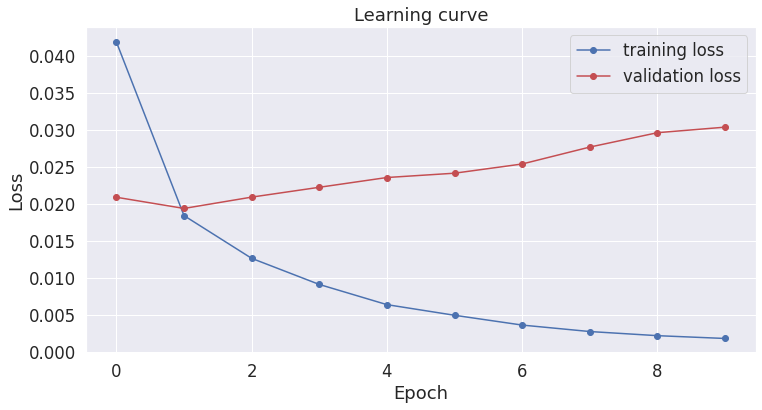

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [37]:
test = torch.tensor(test_i).cuda()
with torch.no_grad():
    output = model(test)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

RuntimeError: CUDA out of memory. Tried to allocate 5.89 GiB (GPU 1; 15.78 GiB total capacity; 9.84 GiB already allocated; 4.52 GiB free; 9.92 GiB reserved in total by PyTorch)

In [38]:
test = torch.tensor(test_i).cuda()

In [39]:
label_indices = []
for i in range(0,len(test),bs):
    #batch = [t.to(device) for t in test[i:i+bs]]
    inputs = test[i:i+bs]
        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
    with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
        output = model(inputs)
    label_indice = np.argmax(output[0].to('cpu').numpy(), axis=2)
    label_indices.append(label_indice)

In [40]:
label_indices = [elem for twod in label_indices for elem in twod]

In [41]:
# join bpe split tokens
all_pred_labels = []
all_true_labels = []
all_tokens = []
for i in range(test.size()[0]):
    tokens = tokenizer.convert_ids_to_tokens(test.to('cpu').numpy()[i])
    new_tokens, new_labels, true_labels = [], [], []
    for token, label_idx, true_label_idx in zip(tokens, label_indices[i], test_tags[i]):
        if(token == '[PAD]'):
            continue
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
            true_labels.append(tag_values[true_label_idx])
    all_pred_labels.append(new_labels)
    all_tokens.append(new_tokens)
    all_true_labels.append(true_labels)
#     for token, label, true_label in zip(new_tokens, new_labels, true_labels):
#         print("{}\t{}\t{}".format(label, token, true_label))


In [42]:
from seqeval.metrics import classification_report

In [43]:
print(classification_report(all_pred_labels, all_true_labels))

/home/shreya15096/.conda/envs/virtualEnv/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Living seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/shreya15096/.conda/envs/virtualEnv/lib/python3.9/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Non-Living seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

      Living       0.73      0.80      0.76      1033
       iving       0.93      0.94      0.93      7223

   micro avg       0.90      0.92      0.91      8256
   macro avg       0.83      0.87      0.85      8256
weighted avg       0.90      0.92      0.91      8256



In [44]:
i = 657
for token, pred, true in zip(all_tokens[i], all_pred_labels[i], all_true_labels[i]):
    print(token, pred, true)

" O O
[UNK] Living Living
enquired O O
what O O
is O O
meant O O
by O O
[UNK] Living Living
. O O
' O O


In [45]:
len(all_tokens)

6867

In [46]:
test_sentence = '''Ganga dipped her feet in the holy Ganga. '''

In [47]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


O	[CLS]
Living	[UNK]
O	dipped
O	her
O	feet
O	in
O	the
O	holy
Non-Living	[UNK]
O	.
O	[SEP]
